In [133]:
from rfa_mlp import (
    NeuralNetwork,
    create_dataset,
    train_test_split,
    train_network,
    create_dataset_with_bad_correlations,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# we are switching off some warning that would arise during the learning dynamics -- not a problem rn
import warnings

warnings.filterwarnings("ignore")

# consistent and slightly nicer plots globally
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

## Theory: Backpropagation vs Random Feedback Alignment

### Standard Backpropagation

Forward pass: $$h_i = f(W_i h_{i-1})$$

Backward pass: $$\delta_{i-1} = W_i^T \delta_i \odot f'(z_i-1)$$

Weight update: $$\Delta W_i = -\eta \delta_i h_{i-1}^Tx$$

### Random Feedback Alignment (RFA!)

Forward pass (same as BP): $$h_i = f(W_i h_{i-1})$$ 

Backward pass (RFA!): $$\delta_{i-1} = B_i^T \delta_i \odot f'(z_i-1)$$

Weight update (same as BP):  $$\Delta W_i = -\eta \delta_i h_{i-1}^T`$$ 

Where $B_i$ is a fixed random matrix that replaces $W_i^T$!

## Task 1: Implement the RFA version of learning!

1. Create a class RandomFeedbackNetwork, similar to BackpropNetwork
2. Make sure you can instantiate an object of that class, and train on the provided toy data.
3. Plot your results!

In [134]:
class BackpropNetwork(NeuralNetwork):
    """The NeuralNetwork class takes care of the forward pass and
    tracking all the weights and states in the network (biases, weights, hs, zs).
    The only thing left to do is to update the parameters according to backprop like so:"""

    def backward(self, target, learning_rate):
        batch_size = target.shape[1]

        # loss derivative at the output:
        delta = self.h[-1] - target

        # walk backwards through the layers.
        for i in range(self.num_layers - 1, -1, -1):
            dW = (delta @ self.h[i].T) / batch_size
            db = np.mean(delta, axis=1, keepdims=True)

            self.W[i] -= learning_rate * dW
            self.b[i] -= learning_rate * db

            if i > 0:
                delta = (self.W[i].T @ delta) * self._d_act(self.z[i - 1])

        return delta

In [135]:
class RandomFeedbackNetwork(NeuralNetwork):
    """For a Random Feedback Alignment network we need to remember a little bit
    more about the network. Then, we have to implement a new backward pass!"""

    def __init__(self, layer_sizes):
        super().__init__(layer_sizes)
        self.B = []
        for i in range(self.num_layers):
            b = np.random.randn(
                layer_dims[i],
                layer_dims[i + 1],
            )
            self.B.append(b)

    def backward(self, target, learning_rate):
        """Backward pass using random feedback alignment"""

        # check the "train_network" function to see how backward is used for additional context
        batch_size = target.shape[1]

        # loss derivative at the output:
        delta = self.h[-1] - target

        # walk backwards through the layers.
        for i in range(self.num_layers - 1, -1, -1):
            dW = (delta @ self.h[i].T) / batch_size
            db = np.mean(delta, axis=1, keepdims=True)

            self.W[i] -= learning_rate * dW
            self.b[i] -= learning_rate * db

            if i > 0:
                delta = (self.B[i] @ delta) * self._d_act(self.z[i - 1])

        return delta

In [136]:
# we will train a simple, but already "deep" network:
layer_dims = [
    10,
    10,
    10,
    5,
]  # this means: 10 inputs, 2 hidden layers with 10 units, one linear output layer with 5 units.
bp_network = BackpropNetwork(layer_dims)

X, y = create_dataset()  # 10 inputs 5 outputs by default

X_train, X_test, y_train, y_test = train_test_split(X, y)  # splits off 20% for testing

# train network, by default, uses batch_size 32, learning rate 0.01, and 500 epochs.
# This should just work!
bp_train_losses, bp_test_losses = train_network(
    bp_network, X_train, y_train, X_test, y_test
)

Epoch 0: Train Loss = 0.2929, Test Loss = 0.2567
Epoch 100: Train Loss = 0.0153, Test Loss = 0.0158
Epoch 200: Train Loss = 0.0079, Test Loss = 0.0084
Epoch 300: Train Loss = 0.0063, Test Loss = 0.0067
Epoch 400: Train Loss = 0.0057, Test Loss = 0.0061


In [137]:
# this should work once you've implemented the rfa network!

rfa_network = RandomFeedbackNetwork(layer_dims)
rfa_train_losses, rfa_test_losses = train_network(
    rfa_network, X_train, y_train, X_test, y_test
)

Epoch 0: Train Loss = 0.4136, Test Loss = 0.3583
Epoch 100: Train Loss = 0.0112, Test Loss = 0.0122
Epoch 200: Train Loss = 0.0078, Test Loss = 0.0084
Epoch 300: Train Loss = 0.0067, Test Loss = 0.0071
Epoch 400: Train Loss = 0.0063, Test Loss = 0.0066


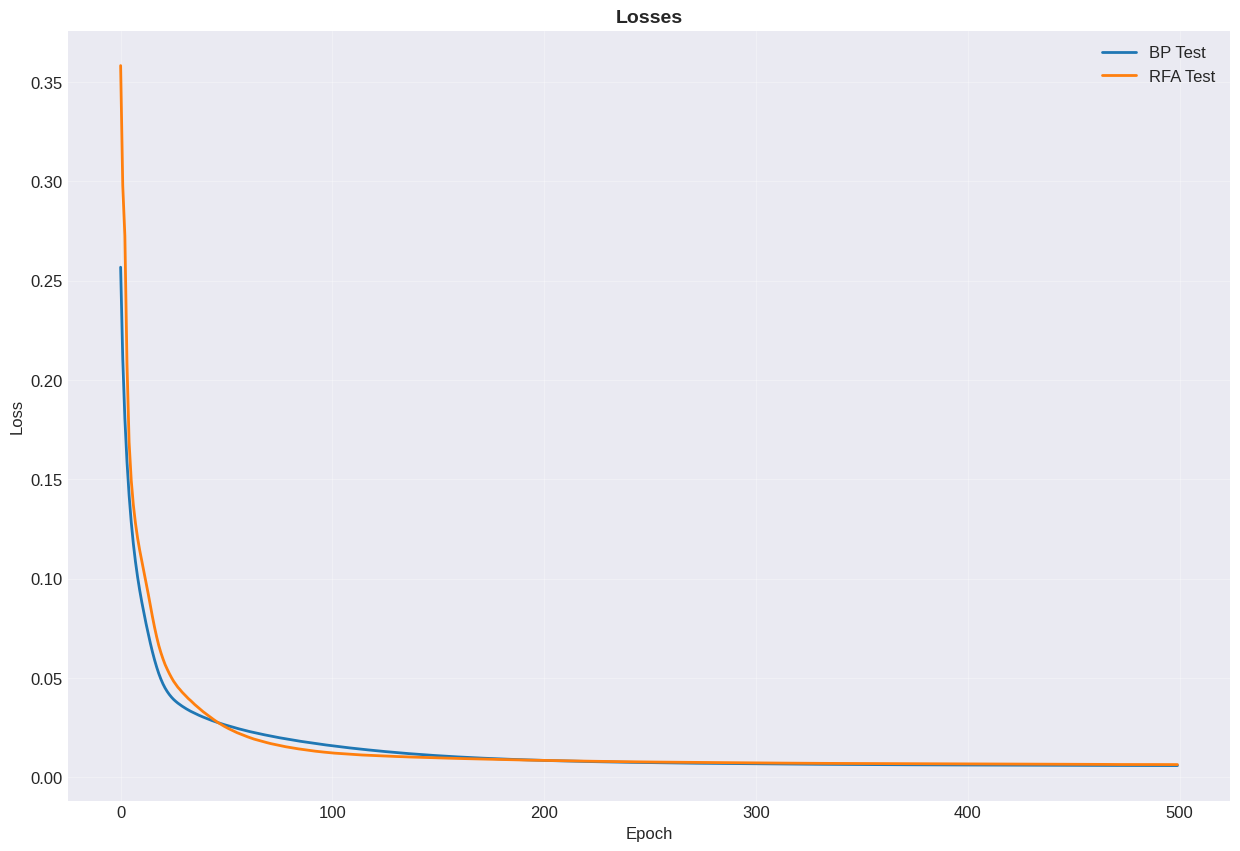

In [138]:
# Visualize results // add the RFA results here!
fig, ax1 = plt.subplots(figsize=(15, 10))

# results
ax1.plot(bp_test_losses, label="BP Test", linewidth=2)
ax1.plot(rfa_test_losses, label="RFA Test", linewidth=2)
# ax1.plot(bp_train_losses, label="BP Train", linewidth=2, linestyle='--')
# ax1.plot(rfa_train_losses, label="RFA Train", linewidth=2, linestyle='--')
ax1.set_title("Losses", fontsize=14, fontweight="bold")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

## Task 2
One feature of RFA networks is, that they tend to "align" the feedforward weights with the randomly chosen "backprop" weights B. Compute this alignment and track alignment during training (additional instructions in comments!

Then, plot alignment of each layer's weights with the B matrix.

In [139]:
def compute_alignment(network):
    """Compute alignment between forward and backward matrices, only use for RFA
    returns alignments (for each layer in the current network)
    """
    # first, this should compute the "frobenius norm" (or the sum of dot prodcuts of all colums --
    # there is a simple way to express this with only one dot product!).
    # from this, you can get the cosine_similarity for the two matricies, which you can convert into angles.
    # do this for each layer.
    alignments = []

    for W, B in zip(network.W, network.B):
        # calculate forbenius norm of matrix W and B
        # W_norm = np.linalg.norm(W, ord="fro")
        # B_norm = np.linalg.norm(W, ord="fro")
        # cosine_similarity = np.dot(W, B) / (W_norm * B_norm)
        # alignment = np.degrees(np.arccos(cosine_similarity))

        cosine_similarity = np.dot(W.flatten(), B.T.flatten()) / (
            np.linalg.norm(W, ord="fro") * np.linalg.norm(B, ord="fro")
        )
        alignment = np.degrees(np.arccos(cosine_similarity))

        alignments.append(alignment)

    return alignments


# Track alignment over training, i.e. do the training, but record all the alignements.
def track_alignment_during_training(
    network,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=500,
    learning_rate=0.01,
    batch_size=32,
):
    """Train network and track alignment angles over time
    returns alignments for each layer for all epooch (every 10th epoch recorded"""

    # write a simplified training loop (see attached .py for an example) that collects how
    # well B*delta aligns with the theoretically correct W^T delta for each epoch.
    # you can skip some computations by evaluation the alignment every 10 epochs.

    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    alignments = []

    for epoch in range(epochs):
        # move the train data around for each epoch
        rand_indicies = np.random.permutation(num_samples)
        X_shuffled = X_train[:, rand_indicies]
        y_shuffled = y_train[:, rand_indicies]

        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = batch_start + batch_size

            X_batch = X_shuffled[:, batch_start:batch_end]
            y_batch = y_shuffled[:, batch_start:batch_end]

            # forward:
            prediction = network.forward(X_batch)
            network.compute_loss(prediction, y_batch)

            network.backward(y_batch, learning_rate)

        if epoch % 10 == 0:
            alignment = compute_alignment(network)
            alignments.append(alignment)

    return alignments

In [140]:
rfa_network2 = RandomFeedbackNetwork(layer_dims)
rfa_alignments = track_alignment_during_training(
    rfa_network2, X_train, y_train, X_test, y_test
)

# plot your results

50


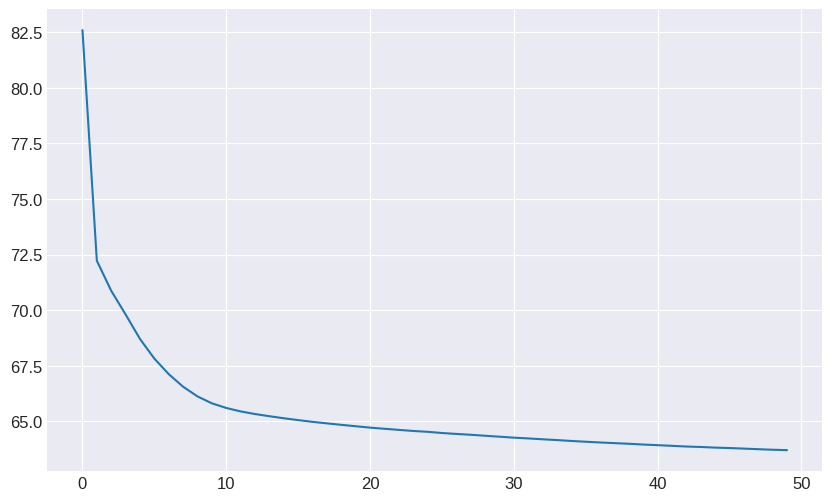

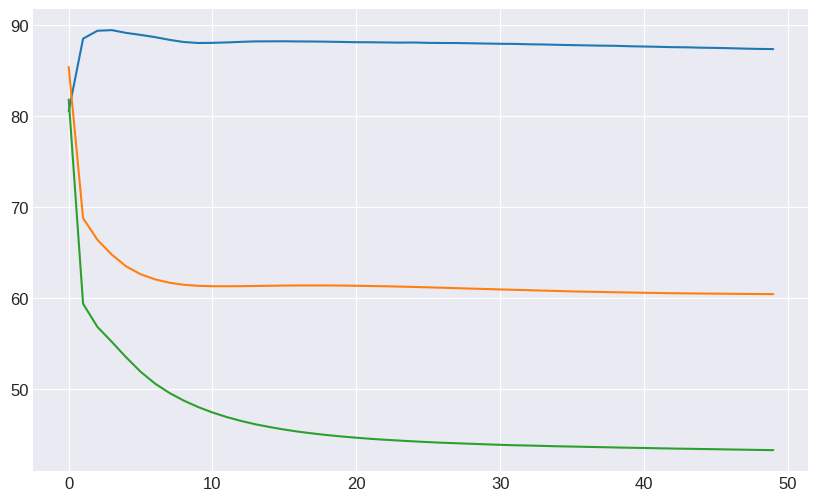

In [141]:
# avg algunemnt per epoch
avg_alignment_per_epoch = np.mean(rfa_alignments, axis=1)
print(len(avg_alignment_per_epoch))
plt.plot(avg_alignment_per_epoch)
plt.show()

# plot every dimension as one line in a plot over the 50 steps
for i in range(3):
    plt.plot([alignment[i] for alignment in rfa_alignments])
plt.show()

## Task 3

What do you think happens when inputs and targets are correlated in RFA? Compare to your backprop expectations. Then, use the provded function to test your hypothesis.

(Note: Because of the toy nature of our problems here, any effect is likly small-ish)


In [142]:
X1, y1 = create_dataset_with_bad_correlations()  # 10 inputs 5 outputs by default

In [143]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B = np.array([[2, 2, 2], [2, 2, 2], [3, 1, 1]])

norm_1 = A.flatten() * B.flatten()
norm_1_sum = np.sum(norm_1)

norm_2 = np.dot(A.flatten(), B.T.flatten())

norm_2_sum = np.sum(norm_2)

norm_3 = np.dot(A, B)

norm_4 = np.linalg.norm(A, ord="fro") * np.linalg.norm(B, ord="fro")

norm_5 = np.dot(A.flatten(), A.flatten())
norm_6 = np.dot(B.flatten(), B.flatten())
norm_7 = norm_5 * norm_6

print("norm_1: ", norm_1)
print("norm_1_sum: ", norm_1_sum)
print("norm_2: ", norm_2)
print("norm_3: ", norm_3)
print("norm_4: ", norm_4)
print("norm_5: ", norm_5)
print("norm_6: ", norm_6)
print("norm_7: ", norm_7)

norm_1:  [ 2  4  6  8 10 12 21  8  9]
norm_1_sum:  80
norm_2:  78
norm_3:  [[15  9  9]
 [36 24 24]
 [57 39 39]]
norm_4:  99.8749217771909
norm_5:  285
norm_6:  35
norm_7:  9975
